In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/genius-song-lyrics-with-language-information/song_lyrics.csv


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import string, os 
import tensorflow as tf

# keras module for building LSTM 
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dropout, LSTM, Dense, Bidirectional 
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential

In [3]:
df = pd.read_csv('/kaggle/input/genius-song-lyrics-with-language-information/song_lyrics.csv')

In [4]:
# first few rows
df.head()

,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language
0,Killa Cam,rap,Cam'ron,2004,173166,"{""Cam\\'ron"",""Opera Steve""}","[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...",1,en,en,en
1,Can I Live,rap,JAY-Z,1996,468624,{},"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...",3,en,en,en
2,Forgive Me Father,rap,Fabolous,2003,4743,{},Maybe cause I'm eatin\nAnd these bastards fien...,4,en,en,en
3,Down and Out,rap,Cam'ron,2004,144404,"{""Cam\\'ron"",""Kanye West"",""Syleena Johnson""}",[Produced by Kanye West and Brian Miller]\n\n[...,5,en,en,en
4,Fly In,rap,Lil Wayne,2005,78271,{},"[Intro]\nSo they ask me\n""Young boy\nWhat you ...",6,en,en,en


In [5]:
# drop tag, year, views, features, artist
df.drop(['tag','year','views', 'features', 'artist'],axis=1,inplace=True)

In [6]:
# shape
df.shape

(5134856, 6)

In [7]:
# no of sinhala songs in the dataset
df['language'].value_counts().loc['si']

302

In [8]:
df['language_cld3'].value_counts().loc['si']

307

In [9]:
df['language_ft'].value_counts().loc['si']

316

In [10]:
# take only sinhala songs
df = df[df['language_ft']=='si']

In [11]:
df.head()

,title,lyrics,id,language_cld3,language_ft,language
214685,සිනාසෙන්න Sinasenna,[Verse 1: Ashanthi]\nThere's a feeling in my m...,238802,en,si,NaN
214692,ඉඟි බිඟි Ingi Bingi,[Intro: Killer B]\nYou know we do it big baby ...,238821,si,si,si
214949,ජීවිතේ විඳින්න Jeewithe Windinna,[Verse 1:]\nවරෙන් යන්න අපිත් එක්ක කන්න බොන්න හ...,239252,si,si,si
214960,මොට්ටු Mottu,[Verse 1: La Signore]\nමාතලේ හැදුව මම ගේ තට්ටු...,239292,si,si,si
214993,Tum Hi Ho Sinhala RnB Remake නුඹ නැති ලෝකේ,[Intro]\nනුඹ නැති ලෝකේ පාලුයි මට දැන්\nආයෙත් එ...,239373,si,si,si


In [12]:
# shape
df.shape

(316, 6)

# Data Visualization

In [13]:
# checking the word count of the songs
df['word_count'] = df['lyrics'].apply(lambda x: len(str(x).split()))

In [14]:
df.head()

,title,lyrics,id,language_cld3,language_ft,language,word_count
214685,සිනාසෙන්න Sinasenna,[Verse 1: Ashanthi]\nThere's a feeling in my m...,238802,en,si,NaN,273
214692,ඉඟි බිඟි Ingi Bingi,[Intro: Killer B]\nYou know we do it big baby ...,238821,si,si,si,369
214949,ජීවිතේ විඳින්න Jeewithe Windinna,[Verse 1:]\nවරෙන් යන්න අපිත් එක්ක කන්න බොන්න හ...,239252,si,si,si,299
214960,මොට්ටු Mottu,[Verse 1: La Signore]\nමාතලේ හැදුව මම ගේ තට්ටු...,239292,si,si,si,143
214993,Tum Hi Ho Sinhala RnB Remake නුඹ නැති ලෝකේ,[Intro]\nනුඹ නැති ලෝකේ පාලුයි මට දැන්\nආයෙත් එ...,239373,si,si,si,162


In [15]:
# statistical info
df['word_count'].describe()

count     316.000000
mean      271.477848
std       194.569177
min        28.000000
25%       125.750000
50%       233.000000
75%       364.000000
max      1613.000000
Name: word_count, dtype: float64

Text(0.5, 1.0, 'Frequency distribution of number of words for each text extracted')

<Figure size 1200x600 with 0 Axes>

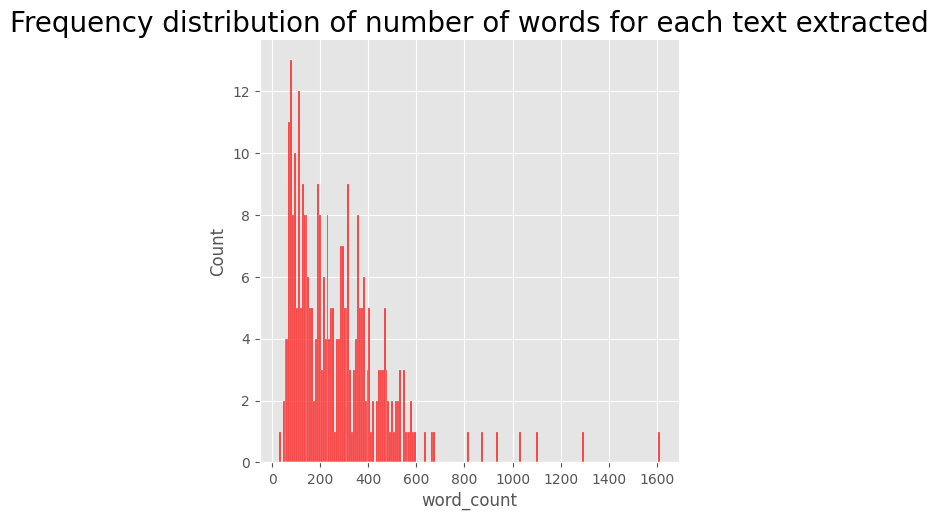

In [16]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.displot(df['word_count'],kde = False,color="red",bins=200)
plt.title("Frequency distribution of number of words for each text extracted", size=20)

# Preprocessing

In [17]:
#drop all records with more than 600 word_count
df = df[df['word_count'] <= 600]

In [18]:
df.shape

(306, 7)

In [19]:
# Tokenization
tokenizer = Tokenizer()
# Fit the tokenizer on the lowercased lyrics column in the DataFrame
tokenizer.fit_on_texts(df['lyrics'].astype(str).str.lower())

# Calculate the total number of unique words in the lyrics dataset
total_words = len(tokenizer.word_index)+1
# Tokenize the lyrics using the fitted tokenizer
tokenized_sentences = tokenizer.texts_to_sequences(df['lyrics'].astype(str))
# Print the tokenized sentence for the first entry in the DataFrame
tokenized_sentences[0]

[15,
 60,
 1925,
 2363,
 126,
 1642,
 249,
 111,
 1926,
 468,
 533,
 8000,
 369,
 48,
 223,
 111,
 2364,
 8001,
 1432,
 111,
 775,
 185,
 1927,
 48,
 628,
 126,
 8002,
 261,
 249,
 61,
 8003,
 5088,
 5089,
 8004,
 186,
 2895,
 369,
 166,
 223,
 111,
 8005,
 469,
 1433,
 17,
 5090,
 370,
 2896,
 4,
 371,
 5091,
 2896,
 1140,
 5092,
 5093,
 5094,
 125,
 5095,
 717,
 3714,
 21,
 1433,
 2365,
 320,
 1141,
 670,
 1928,
 3715,
 241,
 2897,
 151,
 2898,
 280,
 846,
 250,
 10,
 1929,
 57,
 280,
 1643,
 2366,
 718,
 3716,
 3717,
 15,
 53,
 1925,
 2899,
 560,
 1028,
 126,
 2900,
 185,
 1434,
 1142,
 8006,
 166,
 223,
 321,
 204,
 1285,
 938,
 111,
 1435,
 185,
 1436,
 186,
 1432,
 48,
 3718,
 938,
 111,
 1435,
 2901,
 3719,
 1644,
 249,
 61,
 8007,
 1434,
 223,
 204,
 2902,
 1434,
 223,
 204,
 2902,
 1930,
 3720,
 223,
 2367,
 938,
 111,
 8008,
 1437,
 5096,
 186,
 126,
 8009,
 1645,
 48,
 223,
 2368,
 469,
 1433,
 17,
 5090,
 370,
 2896,
 4,
 371,
 5091,
 2896,
 1140,
 5092,
 5093,
 5094,
 125,

In [20]:
# Slash sequences into n-gram sequences
input_sequences = list()

# Iterate over each tokenized sentence
for i in tokenized_sentences:
    # Iterate over each token in the tokenized sentence
    for t in range(1, len(i)):
        # Create an n-gram sequence from the beginning to the current token
        n_gram_sequence = i[:t+1]
        # Append the n-gram sequence to the list of input sequences
        input_sequences.append(n_gram_sequence)

# prepadding
# Find the maximum sequence length among all input sequences
max_sequence_len = max([len(x) for x in input_sequences])

# Convert the list of input sequences into a numpy array with pre-padding
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [21]:
# Display the first 10 entries of the input_sequences array
input_sequences[:10]

array([[   0,    0,    0, ...,    0,   15,   60],
       [   0,    0,    0, ...,   15,   60, 1925],
       [   0,    0,    0, ...,   60, 1925, 2363],
       ...,
       [   0,    0,    0, ...,  249,  111, 1926],
       [   0,    0,    0, ...,  111, 1926,  468],
       [   0,    0,    0, ..., 1926,  468,  533]], dtype=int32)

In [22]:
# create predictors and label
X, labels = input_sequences[:,:-1],input_sequences[:,-1]
y = tf.keras.utils.to_categorical(labels, num_classes=total_words)

# LSTM model development

In [23]:
model = Sequential()
model.add(Embedding(total_words, 10, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(250)))
model.add(Dropout(0.1))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
earlystop = EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto')
history = model.fit(X, y, epochs=5, verbose=1, callbacks=[earlystop])

Epoch 1/5
2337/2337 [==============================] - 3570s 2s/step - loss: 8.9192 - accuracy: 0.0117
Epoch 2/5
2337/2337 [==============================] - 3711s 2s/step - loss: 8.3051 - accuracy: 0.0177
Epoch 3/5
2337/2337 [==============================] - 3667s 2s/step - loss: 7.7258 - accuracy: 0.0352
Epoch 4/5
2337/2337 [==============================] - 3616s 2s/step - loss: 7.0979 - accuracy: 0.0697
Epoch 5/5
2337/2337 [==============================] - 3659s 2s/step - loss: 6.2698 - accuracy: 0.1203
